# Reconnaissance de chiffre en language des signes avec pytorch

Dans cette exemple d'utilisation de deep learning, nous allons utiliser une base de donnée de 2061 images de mains faisant un chiffre en language des signes. Ces images sont en nuances de gris et dans une de plage de 0 à 1.
Nous disposons également des vérités terrains associés à chaque image sous forme d'un tableau de taille 10 avec un 1 à l'index de la classe correspondante.

Pour effectuer l'apprentissage nous allons utiliser pytorch.

## Chargement des images

In [122]:
#Import des modules pythons nécessaires
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from PIL import Image
import numpy as np
import torch.utils.data as utils
from random import shuffle
import matplotlib.pyplot as plt
from itertools import chain, combinations
import time
from IPython.display import clear_output
#Affichage de la graine d'aléatoire actuelle (afin de reproduire des résultats si nécessaire)
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#Chargement de cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Random Seed:  4660


Avant d'aller plus en profondeur avec des réseaux de neurone il faut tout d'abord charger les données.
Pour cela nous chargons directement les images via numpy et pour et les vérités terrains nous avons décider de ramener le tableau à 1 unique valeur représentant l'axe.
Pour avoir des datasets cohérents nous allons également faire en sorte qu'il soit homogène (en tout cas pour le training set).

Nous commençons par charger les images et les classes.

In [123]:

#Chargement des images
images_base = [Image.fromarray(im) for im in np.load("./datas/X.npy")]
#Chargement des classes
classes_base = np.load("./datas/Y.npy")

Transformation du dataset en appliquant une liste de transformation.

Nombre de transformation :  2


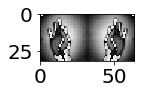

In [124]:
#L'image est d'abord redimmensionnée
#Puis noramlisé entre -0.5 et 0.5
Trans_Base = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
#Définition des opérations de transformations des images (augmentation de donnée)
Trans_ops = [transforms.functional.hflip]#,transforms.RandomAffine(35,(0.1,0.1))
             #,transforms.RandomAffine(10),transforms.RandomAffine(10,(0.3,0.3))]
#Definition de toute les transformations possibles par composition
Trans_ops =  list(chain.from_iterable(combinations(Trans_ops,n) for n in range(len(Trans_ops)+1)))
images = []
temp = []
first = True
counter = 0
#Création d'une image d'example des différentes opérations de transformations
example = Image.new('L',(32*len(Trans_ops),32))
print("Nombre de transformation : ",len(Trans_ops))
for trans in Trans_ops:
    for im in images_base:
        temp_im = im
        for t in trans:
            temp_im = t(temp_im)
        images.append(Trans_Base(temp_im))
        if first:
            first = False
            example.paste(transforms.ToPILImage()(Trans_Base(temp_im)).convert('RGB'),(32*counter,0))
    for cl in classes_base:
        temp.append(cl)
    counter += 1
    first = True
plt.subplot(4,1,1)
plt.imshow(example)

Partionnement du dataset en classe pour produire des datasets d'entraînement et de test homogènes

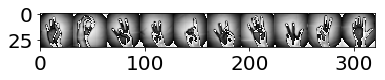

In [125]:
#Création d'une image d'example
example = Image.new('L',(32*10,32))
classes = np.zeros(len(images))
#Initialisation du dataset
separate_classes = []
for i in range(10):
    separate_classes.append([])
    separate_classes[i] = []
for i in range(len(classes)):
    classes[i] = temp[i].nonzero()[0][0]
    separate_classes[int(classes[i])].append(images[i])
counter = 0
for ims in separate_classes:
    example.paste(transforms.ToPILImage()(ims[0]),(32*counter,0))
    counter += 1
plt.subplot(4,1,2)
plt.imshow(example)
#Mélange de chaque sous dataset
for ims in separate_classes:
    shuffle(ims)
#Préparation des partitions
train_set = []
test_set = []
for i in range(10):
    train_set.append([])
    test_set.append([])
prc_train = int(0.80*len(separate_classes[0]))
#Partition des tableaux
counter = 0
for Set in separate_classes:
    train_set[counter] = Set[:prc_train]
    test_set[counter] = Set[prc_train:]
    counter += 1
#Rassemblement des partitions en 2 datasets distincts
full_train = []
full_train_label = []
full_test = []
full_test_label = []
for i in range(10):
    full_train = full_train + train_set[i]
    for j in range(len(train_set[i])):
        full_train_label.append(i)
    full_test = full_test + test_set[i]
    for j in range(len(test_set[i])):
        full_test_label.append(i)

Affichage des repartitions des classes selon le dataset.

Number of training images :  3260
Number of testing images :  864


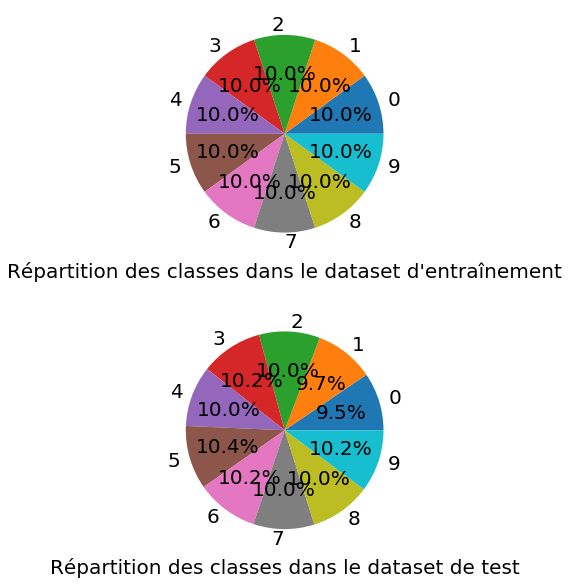

In [126]:
#Affichage du nombre d'élément dans les partitions
print("Number of training images : ",len(full_train))
print("Number of testing images : ",len(full_test))
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
#Calcul des proportions de labels du training set
labels = []
values = []
for i in range(10):
    labels.append(i)
    values.append(0)
for d in full_train_label:
    values[d] += 1
plt.pie(values,labels=labels,autopct='%1.1f%%')
plt.xlabel("Répartition des classes dans le dataset d'entraînement")
plt.subplot(2,1,2)
#Calcul des proportions de labels du test set
labels = []
values = []
for i in range(10):
    labels.append(i)
    values.append(0)
for d in full_test_label:
    values[d] += 1
plt.pie(values,labels=labels,autopct='%1.1f%%')
plt.xlabel("Répartition des classes dans le dataset de test")
plt.show()

Finalement il ne reste plus qu'à convertir les datasets en tensor puis en data loader pour les rendre itérables lors d'un entraînement.

In [127]:
#Conversion des datasets en Tensor
tensor_x_train = torch.stack([torch.Tensor(i) for i in full_train])
tensor_y_train = torch.LongTensor(full_train_label)
tensor_x_test = torch.stack([torch.Tensor(i) for i in full_test])
tensor_y_test = torch.LongTensor(full_test_label)
#Création des dataloaders
datas_train = utils.TensorDataset(tensor_x_train,tensor_y_train)
dataloader_train = utils.DataLoader(datas_train,50, shuffle=True)
datas_test = utils.TensorDataset(tensor_x_test,tensor_y_test)
dataloader_test = utils.DataLoader(datas_test,50, shuffle=True)
plt.rcParams.update({'font.size':20})

Ensuite il faut définir les fonctions d'entraînements et de test associé pour entraîner nos réseaux.
On définit également un test de confusion, pour afficher le type d'erreur qu'effectue le réseau sur le dataset de test.

In [128]:
def train(model, dataloader_train, optimizer, epoch, criterion):
    """
    Entraine un model sur un dataset
    """
    model.train()
    sum_loss = 0
    for i, (data,target) in enumerate(dataloader_train, 0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
        return loss.item()
    
def test(model, test_loader,criterion,epoch,max_epoch):
    """
    Test un model sur un dataset
    """
    clear_output(wait=True)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data,target) in enumerate(test_loader, 0):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item() # somme des batchs
            pred = output.argmax(dim=1, keepdim=True) # récupération l'index de la meilleure proba
            correct += pred.eq(target.view_as(pred)).sum().item()#Comparaison à la vérité
    test_loss /= len(test_loader.dataset)
    print('Test set[{}/{}]: Loss moyenne : {:.4f}, Précision: {}/{} ({:.0f}%)\n'.format(
        epoch,max_epoch,
        test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

def test_confusion(model, test_loader,criterion):
    """
    Construit la matrice de confusion d'un model sur un dataset
    """
    model.eval()
    #Préparation de la matrice
    matrix = list(range(10))
    for x in range(10):
        matrix[x] = list(range(10))
        for y in matrix[x]:
            matrix[x][y] = 0
    with torch.no_grad():
        for i, (data,target) in enumerate(test_loader, 0):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) # récupération l'index de la meilleure proba
            pred_list = pred.flatten().tolist()
            target_list = target.flatten().tolist()
            for T in range(len(pred_list)):
                matrix[pred_list[T]][target_list[T]] += 1
        #Affichage de la matrice
        fig,ax = plt.subplots()
        plt.imshow(matrix,aspect='auto')
        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        ax.set_xticklabels(range(10))
        ax.set_yticklabels(range(10))
        ax.set_xlabel("Prediction")
        ax.set_ylabel("Target")
        ax.set_title("Matrice de confusion")
        fig.tight_layout()
        for i in range(10):
            for j in range(10):
                text = ax.text(j,i,matrix[i][j],ha="center",va="center",color="w")
        plt.show()
        
#List de statistique des models
model_stat_names = []
model_stat_acc = []

def train_model(model,criterion,n_epoch,name):
    """
    Entraînement général d'un réseau comprenant l'entraînement et le test
    Effectue également l'enregistrement du meilleur réseau
    """
    epoch_arr = range(n_epoch)
    train_loss = []
    test_loss = []
    max_test = 0
    start_time = time.time()
    #Entrainement
    for epoch in epoch_arr:
        train_loss.append( train(model, dataloader_train, optimizer, epoch, criterion))
        loss,test_prc = test(model, dataloader_test,criterion,epoch,n_epoch)
        if test_prc > max_test:
            max_test = test_prc
            torch.save(model.state_dict(), './best_'+name+'.pth')
        test_loss.append( loss )
    print("Temps écoulé : ","{0:.2f}".format(time.time() - start_time),"secondes")
    print("max acc : ",max_test)
    #Affichage des courbes de loss
    plt.plot(epoch_arr,train_loss,'b')
    plt.plot(epoch_arr,test_loss,'g')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    #Chargement du dernier meilleur model
    model.load_state_dict(torch.load("./best_"+name+".pth"))
    test_confusion(model, dataloader_test,criterion)
    model_stat_names.append(name)
    model_stat_acc.append(max_test)
    return name,max_test



## Réseau full connected

Maintenant nous pouvons passer à la définition de notre réseau, nous allons tout d'abord commencer avec un perceptron multicouche.

In [129]:
class Net_FC(nn.Module):
    def __init__(self):
        super(Net_FC, self).__init__()
        self.fc1 = nn.Linear(32*32,600)
        self.fc2 = nn.Linear(600, 200)
        self.fc3 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = x.view(-1,32*32)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) #Utilisation de dropout pour ajouter de l'aléatoire à l'entraienement
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
criterion = F.nll_loss
model = Net_FC().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

Il est maintenant temps de lancer notre premier apprentissage et voir les résultats

Test set[499/500]: Loss moyenne : 0.9508, Précision: 612/864 (71%)

Temps écoulé :  10.32 secondes
max acc :  71.29629629629629


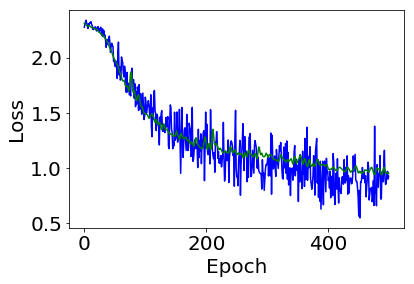

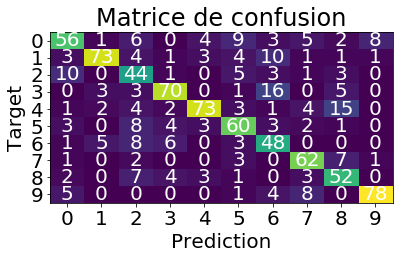

('full_connected', 71.29629629629629)

In [130]:
train_model(model,criterion,500,"full_connected")


Les résultats sont très peu concluant, on peut maintenant esasyer avec un réseau à convolution que l'on termine avec 2 couches full connected.

## Réseau à convolution

In [131]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, 1)
        self.conv2 = nn.Conv2d(64, 128, 5, 1)
        self.fc1 = nn.Linear(5*5*128, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x= self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*128)#Modification de la forme des donneés pour les faire rentrer dans les couches full connected
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) #Utilisation de dropout pour ajouter de l'aléatoire à l'entraienement
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
criterion =  F.nll_loss
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Test set[499/500]: Loss moyenne : 0.3679, Précision: 755/864 (87%)

Temps écoulé :  37.88 secondes
max acc :  89.58333333333333


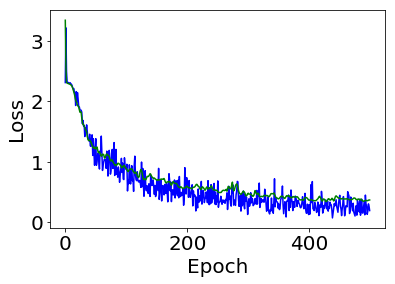

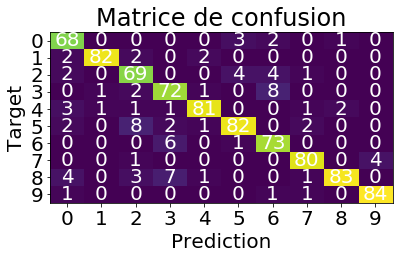

('full_conv', 89.58333333333333)

In [132]:
train_model(model,criterion,500,"full_conv")

## Réseau residuel

Ici les résultats sont bien meilleurs pouvant atteindre les 95%.

Mais il est possible d'aller encore plus loin avec des architectures bien plus complexes.
Pour cette expérimentation nous allons essayer de construire une architecture de type ResNet (pour Residual Network).
Le principe est simple, après chaque convolution il y a une perte de l'information d'origine, ainsi pour pouvoir conserver ces informations lors du traitement il suffit de sauvegarder les données avant un ensemble de convolution, puis de venir les ajouter à la fin d'un ensemble de convolution. Ce type de d'opération s'appel un block résiduel, dans notre cas nous allons construire des blocks de 2 convolution 3*3, et pour venir injecter les données nous allons simplement faire la somme après la 2ème convolution.
Nous allons également utiliser des batchnorms entre chaque convolution pour améliorer les performances du réseau.
Ensuite notre réseau final sera constitué 4 bloc résiduel suivit de 2 couches full connected pour ramener l'informations à un ensemble traitable.

In [133]:
def conv3x3(in_planes, out_planes, stride=1):
    """Convolution 3*3 conservant la taille initiale de l'image en utilsant un padding de 1"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
padding=1, bias=False)

class ResBlock(nn.Module):
    """Définition d'un bloc résiduel"""
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        #Ajoute une couche supplémentaire pour redimenssioner le résidu si il ne possède pas la même
        #forme que la sortie des convolutions
        if inplanes != planes:
            self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes))
        else:
            self.downsample = None
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Net_RES_32(nn.Module):
    def __init__(self):
        super(Net_RES_32, self).__init__()
        self.b1 = ResBlock(1,32)
        self.b2 = ResBlock(32,32)
        self.b3 = ResBlock(32,64)
        #self.b4 = ResBlock(64,128)
        self.fc1 = nn.Linear(64*4*4, 300)
        #self.fc1_b = nn.Linear(800, 200)
        self.fc2 = nn.Linear(300, 10)

    def forward(self, x):
        x = self.b1(x)
        x = F.max_pool2d(x,2)

        x = self.b2(x)
        x = F.max_pool2d(x,2)

        x = self.b3(x)
        x = F.max_pool2d(x,2)
        #x = self.b4(x)
        #x = F.max_pool2d(x,2)

        x = x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc1_b(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
criterion =  F.nll_loss
model = Net_RES_32().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)


Ce réseau étant bien plus complexe que les précédent nous allons l'entraîner jusqu'à 1000 epoch.

Test set[999/1000]: Loss moyenne : 0.1001, Précision: 842/864 (97%)

Temps écoulé :  80.82 secondes
max acc :  98.26388888888889


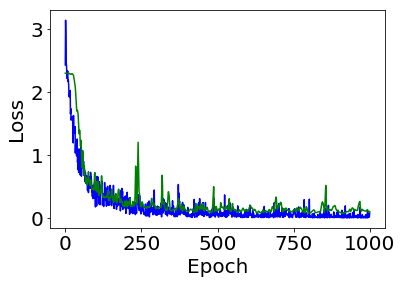

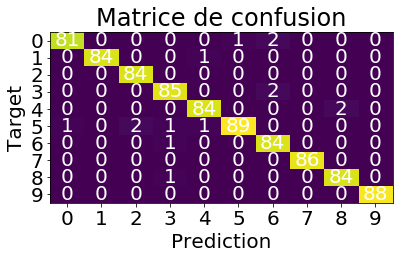

('res', 98.26388888888889)

In [134]:
train_model(model,criterion,1000,"res")

On peut voir qu'avec cette architecture les résultats sont impressionnant et peuvent atteindre les 99%.

## Récapitulatif

In [99]:
print("Nom".ljust(40), "Précision")
for i in range(len(model_stat_names)):
    print(str(model_stat_names[i]).ljust(40),model_stat_acc[i])

Nom                                      Précision
full_connected                           93.63425925925925
full_conv                                92.12962962962963



## Utilisation du réseau

Maintenant que nous avons un réseau foncitonnel il est temps de s'en servir !

Prediction :  9


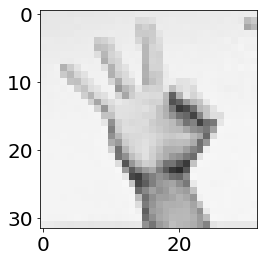

In [136]:
#Extraction et mapping du résultat issu du Tensor (par exemple plusieurs classes représentent un 3)
def map_result(tensor):
    map = {
        0 : 9,
        1 : 0,
        2 : 7,
        3 : 6,
        4 : 1,
        5 : 8,
        6 : 4,
        7 : 3,
        8 : 2,
        9 : 5,
    }
    return map[tensor.argmax(dim=1, keepdim=True)[0][0].item()]
    
    
#Chargement du dernier meilleur model
model.load_state_dict(torch.load("./best_res.pth"))
def test_on(model,path):
    model.eval()
    #Normalisation de l'image
    Trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])
    im = Image.open(path).convert('L').resize((32,32))
    plt.imshow(im)
    #Conversion en variable pytorch
    im = torch.autograd.Variable(Trans(im).unsqueeze_(0))
    #Evaluation
    with torch.no_grad():
            im = im.to(device)
            output = model(im)
            print("Prediction : ",map_result(output))
            
#Test sur une image
#Il suffit de changer le chemin pour essayer sur une image.
test_on(model,"./datas/eval/image_1.jpg")

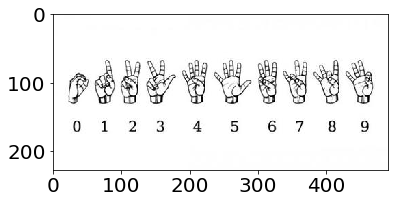

In [72]:
#Affichage d'une image de référence pour vérifier la prédiction
base = Image.open("./datas/eval/base.jpg")
plt.imshow(base)